In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from bart_playground import *
import bartz
from stochtree import BARTModel
import time

## Abalone Data

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features 
y = abalone.data.targets 

# variable information 
print(abalone.variables)

             name     role         type demographic  \
0             Sex  Feature  Categorical        None   
1          Length  Feature   Continuous        None   
2        Diameter  Feature   Continuous        None   
3          Height  Feature   Continuous        None   
4    Whole_weight  Feature   Continuous        None   
5  Shucked_weight  Feature   Continuous        None   
6  Viscera_weight  Feature   Continuous        None   
7    Shell_weight  Feature   Continuous        None   
8           Rings   Target      Integer        None   

                   description  units missing_values  
0         M, F, and I (infant)   None             no  
1    Longest shell measurement     mm             no  
2      perpendicular to length     mm             no  
3           with meat in shell     mm             no  
4                whole abalone  grams             no  
5               weight of meat  grams             no  
6  gut weight (after bleeding)  grams             no  
7        

In [3]:
X.loc[:, 'Sex'] = X['Sex'].map(lambda x: 1 if x == 'M' else 0)
X

/home/ubuntu/bart-playground/venv/lib/python3.10/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,1,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500
1,1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100
3,1,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550
4,0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550
...,...,...,...,...,...,...,...,...
4172,0,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490
4173,1,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605
4174,1,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080
4175,0,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960


In [4]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [5]:
test_mse_results = {name: [] for name in ["bart", "btz", "sto", "rf", "xgb", "lr"]}
train_mse_results = {name: [] for name in ["bart", "btz", "sto", "rf", "xgb", "lr"]}
pi_length_results = {name: [] for name in ["bart", "btz", "sto"]}
time_results = {name: [] for name in ["bart", "btz", "sto", "rf", "xgb", "lr"]}

In [6]:
n_runs = 10
n_skip = 100
n_post = 200
n_trees = 100
for seed in range(n_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
    
    # bart
    t0 = time.time()
    bart = DefaultBART(ndpost=n_post, nskip=n_skip, n_trees=n_trees)
    bart.fit(X_train, y_train)
    time_results["bart"].append(time.time() - t0)
    
    # btz
    t0 = time.time()
    btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=n_trees, ndpost=n_post, nskip=n_skip)
    btpred_all_test = btz.predict(np.transpose(X_test))
    btpred_test = np.mean(np.array(btpred_all_test), axis=0)
    btpred_all_train = btz.predict(np.transpose(X_train))
    btpred_train = np.mean(np.array(btpred_all_train), axis=0)
    time_results["btz"].append(time.time() - t0)
    
    # sto
    t0 = time.time()
    sto = BARTModel()
    sto.sample(X_train=X_train, y_train=y_train,
               num_gfr=0, num_burnin=n_skip, num_mcmc=n_post, 
               mean_forest_params={"num_trees": n_trees})
    sto_pred_all_test = sto.predict(X_test)
    sto_pred_test = np.mean(sto_pred_all_test, axis=1)
    sto_pred_train = np.mean(sto.predict(X_train), axis=1)
    time_results["sto"].append(time.time() - t0)

    # rf
    t0 = time.time()
    rf = RandomForestRegressor(n_estimators=n_trees, random_state=seed)
    rf.fit(X_train, y_train)
    time_results["rf"].append(time.time() - t0)

    # xgb
    t0 = time.time()
    xgbr = xgb.XGBRegressor(n_estimators=n_trees, random_state=seed, verbosity=0)
    xgbr.fit(X_train, y_train)
    time_results["xgb"].append(time.time() - t0)

    # lr
    t0 = time.time()
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    time_results["lr"].append(time.time() - t0)
    
    # Test MSE
    test_mse_results["bart"].append(mean_squared_error(y_test, bart.predict(X_test)))
    test_mse_results["btz"].append(mean_squared_error(y_test, btpred_test))
    test_mse_results["sto"].append(mean_squared_error(y_test, sto_pred_test))
    test_mse_results["rf"].append(mean_squared_error(y_test, rf.predict(X_test)))
    test_mse_results["xgb"].append(mean_squared_error(y_test, xgbr.predict(X_test)))
    test_mse_results["lr"].append(mean_squared_error(y_test, lr.predict(X_test)))

    # Train MSE
    train_mse_results["bart"].append(mean_squared_error(y_train, bart.predict(X_train)))
    train_mse_results["btz"].append(mean_squared_error(y_train, btpred_train))
    train_mse_results["sto"].append(mean_squared_error(y_train, sto_pred_train))
    train_mse_results["rf"].append(mean_squared_error(y_train, rf.predict(X_train)))
    train_mse_results["xgb"].append(mean_squared_error(y_train, xgbr.predict(X_train)))
    train_mse_results["lr"].append(mean_squared_error(y_train, lr.predict(X_train)))

    # Prediction intervals
    # btz: axis=0, shape (n_mcmc, n_test)
    btz_lower = np.percentile(btpred_all_test, 2.5, axis=0)
    btz_upper = np.percentile(btpred_all_test, 97.5, axis=0)
    pi_length_results["btz"].append(np.mean(btz_upper - btz_lower))
    
    # sto: axis=1, shape (n_test, n_mcmc)
    sto_lower = np.percentile(sto_pred_all_test, 2.5, axis=1)
    sto_upper = np.percentile(sto_pred_all_test, 97.5, axis=1)
    pi_length_results["sto"].append(np.mean(sto_upper - sto_lower))
    
    # bart: axis=1, shape (n_test, n_mcmc)
    bart_pred_all_test = bart.posterior_f(X_test)
    bart_lower = np.percentile(bart_pred_all_test, 2.5, axis=1)
    bart_upper = np.percentile(bart_pred_all_test, 97.5, axis=1)
    pi_length_results["bart"].append(np.mean(bart_upper - bart_lower))


Iterations:   0%|          | 0/300 [00:00<?, ?it/s]

Iterations: 100%|██████████| 300/300 [01:27<00:00,  3.41it/s]
INFO:2025-05-27 07:49:07,123:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


Iteration 100/300 P_grow=0.57 P_prune=0.43 A_grow=0.14 A_prune=0.26 (burnin)
Iteration 200/300 P_grow=0.56 P_prune=0.44 A_grow=0.29 A_prune=0.27
Iteration 300/300 P_grow=0.53 P_prune=0.47 A_grow=0.17 A_prune=0.17


Iterations: 100%|██████████| 300/300 [01:12<00:00,  4.16it/s]


Iteration 100/300 P_grow=0.61 P_prune=0.39 A_grow=0.18 A_prune=0.28 (burnin)
Iteration 200/300 P_grow=0.51 P_prune=0.49 A_grow=0.20 A_prune=0.20
Iteration 300/300 P_grow=0.53 P_prune=0.47 A_grow=0.13 A_prune=0.17


Iterations: 100%|██████████| 300/300 [01:19<00:00,  3.79it/s]


Iteration 100/300 P_grow=0.59 P_prune=0.41 A_grow=0.20 A_prune=0.07 (burnin)
Iteration 200/300 P_grow=0.56 P_prune=0.44 A_grow=0.27 A_prune=0.18
Iteration 300/300 P_grow=0.52 P_prune=0.48 A_grow=0.17 A_prune=0.15


Iterations: 100%|██████████| 300/300 [01:15<00:00,  3.99it/s]


Iteration 100/300 P_grow=0.57 P_prune=0.43 A_grow=0.14 A_prune=0.21 (burnin)
Iteration 200/300 P_grow=0.56 P_prune=0.44 A_grow=0.16 A_prune=0.14
Iteration 300/300 P_grow=0.53 P_prune=0.47 A_grow=0.15 A_prune=0.15


Iterations: 100%|██████████| 300/300 [01:13<00:00,  4.07it/s]


Iteration 100/300 P_grow=0.56 P_prune=0.44 A_grow=0.12 A_prune=0.27 (burnin)
Iteration 200/300 P_grow=0.53 P_prune=0.47 A_grow=0.13 A_prune=0.13
Iteration 300/300 P_grow=0.50 P_prune=0.50 A_grow=0.10 A_prune=0.12


Iterations: 100%|██████████| 300/300 [01:14<00:00,  4.02it/s]


Iteration 100/300 P_grow=0.61 P_prune=0.39 A_grow=0.20 A_prune=0.13 (burnin)
Iteration 200/300 P_grow=0.54 P_prune=0.46 A_grow=0.20 A_prune=0.20
Iteration 300/300 P_grow=0.53 P_prune=0.47 A_grow=0.21 A_prune=0.19


Iterations: 100%|██████████| 300/300 [01:17<00:00,  3.87it/s]


Iteration 100/300 P_grow=0.55 P_prune=0.45 A_grow=0.18 A_prune=0.16 (burnin)
Iteration 200/300 P_grow=0.53 P_prune=0.47 A_grow=0.17 A_prune=0.13
Iteration 300/300 P_grow=0.51 P_prune=0.49 A_grow=0.10 A_prune=0.20


Iterations: 100%|██████████| 300/300 [01:08<00:00,  4.40it/s]


Iteration 100/300 P_grow=0.59 P_prune=0.41 A_grow=0.19 A_prune=0.32 (burnin)
Iteration 200/300 P_grow=0.55 P_prune=0.45 A_grow=0.20 A_prune=0.16
Iteration 300/300 P_grow=0.53 P_prune=0.47 A_grow=0.08 A_prune=0.23


Iterations: 100%|██████████| 300/300 [01:11<00:00,  4.20it/s]


Iteration 100/300 P_grow=0.57 P_prune=0.43 A_grow=0.19 A_prune=0.16 (burnin)
Iteration 200/300 P_grow=0.52 P_prune=0.48 A_grow=0.17 A_prune=0.21
Iteration 300/300 P_grow=0.53 P_prune=0.47 A_grow=0.08 A_prune=0.17


Iterations: 100%|██████████| 300/300 [01:13<00:00,  4.07it/s]


Iteration 100/300 P_grow=0.55 P_prune=0.45 A_grow=0.16 A_prune=0.22 (burnin)
Iteration 200/300 P_grow=0.53 P_prune=0.47 A_grow=0.15 A_prune=0.15
Iteration 300/300 P_grow=0.54 P_prune=0.46 A_grow=0.11 A_prune=0.22


In [7]:
import pandas as pd

test_mse_df = pd.DataFrame(test_mse_results)
train_mse_df = pd.DataFrame(train_mse_results)
pi_length_df = pd.DataFrame(pi_length_results)
time_df = pd.DataFrame(time_results)

print(f"Test MSE ({n_runs} runs):")
print(f"Train MSE ({n_runs} runs):")
print("Test MSE Mean:")
print(test_mse_df.mean())
print("Train MSE Mean:")
print(train_mse_df.mean())

print(f"Prediction Interval Mean Length ({n_runs} runs):")
print(f"Prediction Interval Mean Length (Mean over {n_runs} runs):")
print(pi_length_df.mean())

print(f"Average Training Time (seconds) over {n_runs} runs:")
print(time_df.mean())

Test MSE (10 runs):
Train MSE (10 runs):
Test MSE Mean:
bart    4.935929
btz     4.938783
sto     4.840149
rf      4.909739
xgb     5.537300
lr      5.041694
dtype: float64
Train MSE Mean:
bart    3.883408
btz     4.012955
sto     4.052231
rf      0.665650
xgb     0.543513
lr      4.837425
dtype: float64
Prediction Interval Mean Length (10 runs):
Prediction Interval Mean Length (Mean over 10 runs):
bart    1.752215
btz     1.726027
sto     1.636842
dtype: float64
Average Training Time (seconds) over 10 runs:
bart    75.437006
btz      4.996541
sto      4.197625
rf       1.232158
xgb      0.106460
lr       0.002335
dtype: float64


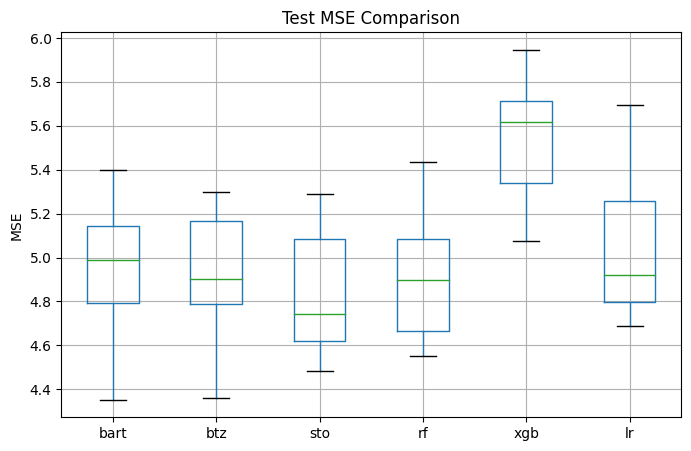

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
test_mse_df.boxplot()
plt.title("Test MSE Comparison")
plt.ylabel("MSE")
plt.grid(True, axis='y')
plt.show()

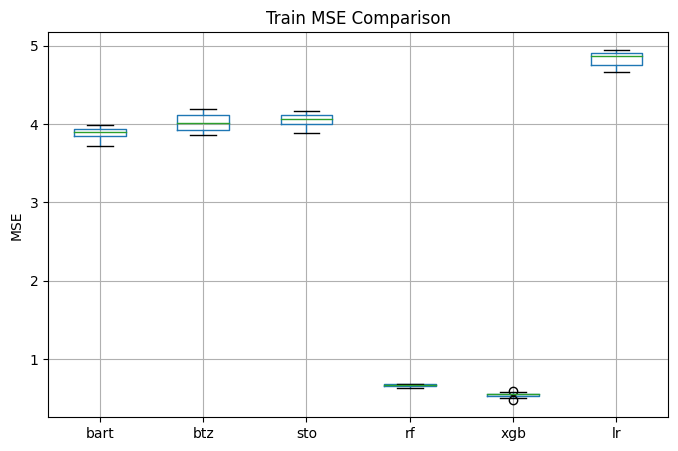

In [10]:
plt.figure(figsize=(8, 5))
train_mse_df.boxplot()
plt.title("Train MSE Comparison")
plt.ylabel("MSE")
plt.grid(True, axis='y')
plt.show()

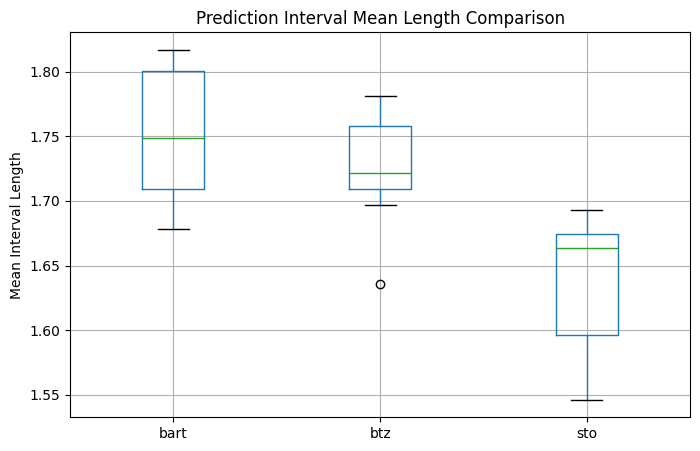

In [11]:
plt.figure(figsize=(8, 5))
pi_length_df.boxplot()
plt.title("Prediction Interval Mean Length Comparison")
plt.ylabel("Mean Interval Length")
plt.grid(True, axis='y')
plt.show()

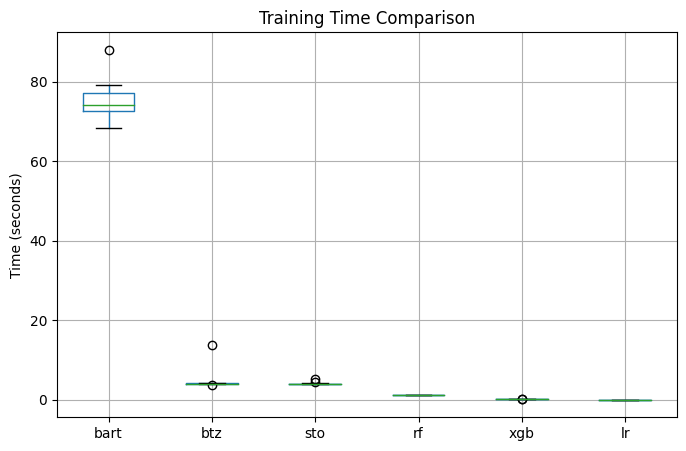

In [12]:
plt.figure(figsize=(8, 5))
time_df.boxplot()
plt.title("Training Time Comparison")
plt.ylabel("Time (seconds)")
plt.grid(True, axis='y')
plt.show()